# Week 9. RecSys Basic

In [1]:
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from surprise import (
    SVD,
    Reader,
    Dataset,
    KNNBasic,
    accuracy,
    KNNWithMeans,
)
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [2]:
movies = pd.read_csv("./ml-latest-small/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
movies["genres"] = movies["genres"].apply(lambda row: row.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [4]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [5]:
genres = Counter()
for row in movies["genres"]:
    genres.update(row)

In [6]:
genres

Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

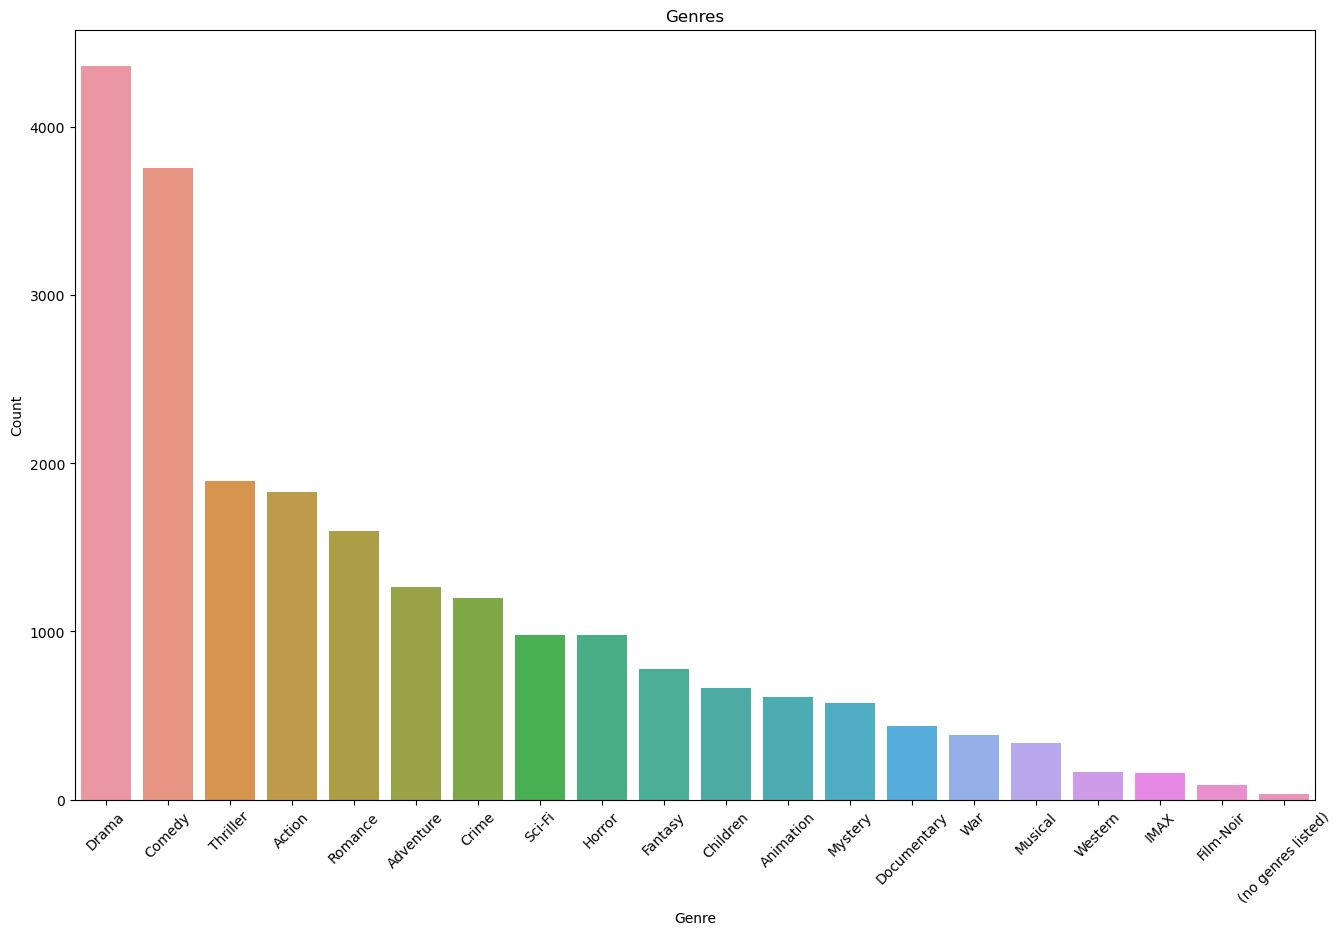

In [7]:
genre_name, genre_count = zip(*genres.most_common())
plt.figure(figsize=(16, 10))
sns.barplot(x=list(genre_name), y=list(genre_count))
plt.xticks(rotation=45)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Count")
plt.show()

In [8]:
ratings = pd.read_csv("./ml-latest-small/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [9]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [10]:
movies = movies.merge(ratings.groupby("movieId")["rating"].agg(["count", "mean"]), on="movieId", how="left")
movies.head()

,movieId,title,genres,count,mean
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",215.0,3.920930
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",110.0,3.431818
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",52.0,3.259615
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",7.0,2.357143
4,5,Father of the Bride Part II (1995),[Comedy],49.0,3.071429


In [11]:
tags = pd.read_csv("./ml-latest-small/tags.csv")
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [12]:
tags["tag"].value_counts()

In Netflix queue     131
atmospheric           36
thought-provoking     24
superhero             24
funny                 23
                    ... 
small towns            1
In Your Eyes           1
Lloyd Dobbler          1
weak plot              1
Heroic Bloodshed       1
Name: tag, Length: 1589, dtype: int64

In [13]:
movies = movies.merge(tags.groupby("movieId")["tag"].apply(list), on="movieId", how="left")
movies.head()

,movieId,title,genres,count,mean,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",215.0,3.920930,"[pixar, pixar, fun]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",110.0,3.431818,"[fantasy, magic board game, Robin Williams, game]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",52.0,3.259615,"[moldy, old]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",7.0,2.357143,NaN
4,5,Father of the Bride Part II (1995),[Comedy],49.0,3.071429,"[pregnancy, remake]"


In [14]:
movies.sort_values(by="mean", ascending=False)

,movieId,title,genres,count,mean,tag
7656,88448,Paper Birds (Pájaros de papel) (2010),"[Comedy, Drama]",1.0,5.0,NaN
8107,100556,"Act of Killing, The (2012)",[Documentary],1.0,5.0,NaN
9083,143031,Jump In! (2007),"[Comedy, Drama, Romance]",1.0,5.0,NaN
9094,143511,Human (2015),[Documentary],1.0,5.0,NaN
9096,143559,L.A. Slasher (2015),"[Comedy, Crime, Fantasy]",1.0,5.0,NaN
...,...,...,...,...,...,...
5749,30892,In the Realms of the Unreal (2004),"[Animation, Documentary]",NaN,NaN,"[Animation, Documentary, Henry Darger]"
5824,32160,Twentieth Century (1934),[Comedy],NaN,NaN,[In Netflix queue]
5837,32371,Call Northside 777 (1948),"[Crime, Drama, Film-Noir]",NaN,NaN,[In Netflix queue]
5957,34482,"Browning Version, The (1951)",[Drama],NaN,NaN,[In Netflix queue]


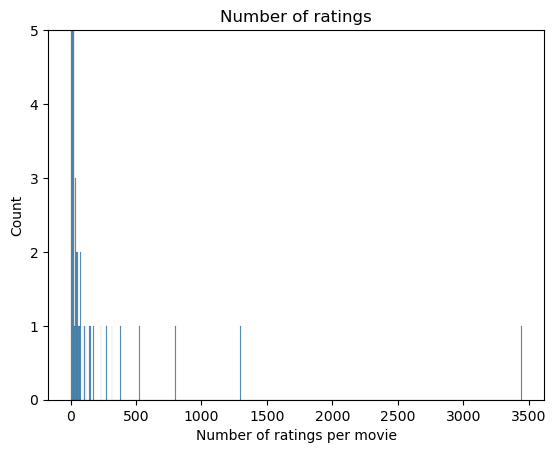

In [15]:
rating_count = movies["count"].value_counts()
sns.histplot(rating_count)
plt.title("Number of ratings")
plt.xlabel("Number of ratings per movie")
plt.ylabel("Count")
plt.ylim(0, 5)
plt.show()

In [16]:
movies[movies["count"] > 50].sort_values(by="mean", ascending=False)

,movieId,title,genres,count,mean,tag
277,318,"Shawshank Redemption, The (1994)","[Crime, Drama]",317.0,4.429022,"[prison, Stephen King, wrongful imprisonment, ..."
659,858,"Godfather, The (1972)","[Crime, Drama]",192.0,4.289062,[Mafia]
2226,2959,Fight Club (1999),"[Action, Crime, Drama, Thriller]",218.0,4.272936,"[dark comedy, psychology, thought-provoking, t..."
975,1276,Cool Hand Luke (1967),[Drama],57.0,4.271930,[prison]
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,"[Comedy, War]",97.0,4.268041,"[dark comedy, Atomic bomb, black comedy, dark ..."
...,...,...,...,...,...,...
144,172,Johnny Mnemonic (1995),"[Action, Sci-Fi, Thriller]",53.0,2.679245,NaN
145,173,Judge Dredd (1995),"[Action, Crime, Sci-Fi]",62.0,2.669355,NaN
376,432,City Slickers II: The Legend of Curly's Gold (...,"[Adventure, Comedy, Western]",55.0,2.645455,NaN
379,435,Coneheads (1993),"[Comedy, Sci-Fi]",63.0,2.420635,NaN


In [17]:
train_dataset, eval_dataset = train_test_split(ratings, test_size=0.2, random_state=42, shuffle=True)

In [18]:
train_dataset = Dataset.load_from_df(
    df=train_dataset[["userId", "movieId", "rating"]],
    reader=Reader(rating_scale=(0, 5))
)
test_dataset = Dataset.load_from_df(
    df=eval_dataset[["userId", "movieId", "rating"]],
    reader=Reader(rating_scale=(0, 5))
)

In [19]:
knn = KNNBasic()
cross_validate(knn, train_dataset, measures=["RMSE", "MAE"], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9583  0.9582  0.9701  0.9551  0.9546  0.9593  0.0056  
MAE (testset)     0.7356  0.7338  0.7450  0.7346  0.7292  0.7357  0.0052  
Fit time          0.05    0.07    0.07    0.07    0.07    0.06    0.01    
Test time         0.62    0.61    0.70    0.61    0.61    0.63    0.04    


{'test_rmse': array([0.95834152, 0.9581919 , 0.97011661, 0.95511995, 0.95458712]),
 'test_mae': array([0.73559188, 0.73378784, 0.74502971, 0.73464555, 0.72923587]),
 'fit_time': (0.04714679718017578,
  0.0651099681854248,
  0.06575274467468262,
  0.0665137767791748,
  0.06519484519958496),
 'test_time': (0.6176242828369141,
  0.611342191696167,
  0.7021820545196533,
  0.6121978759765625,
  0.606011152267456)}

In [20]:
knn_with_means = KNNWithMeans()
cross_validate(knn_with_means, train_dataset, measures=["RMSE", "MAE"], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9056  0.9002  0.9103  0.9041  0.9031  0.9047  0.0033  
MAE (testset)     0.6923  0.6887  0.6979  0.6936  0.6893  0.6924  0.0033  
Fit time          0.07    0.09    0.09    0.09    0.08    0.08    0.01    
Test time         0.67    0.67    0.75    0.67    0.67    0.69    0.03    


{'test_rmse': array([0.90563693, 0.90022427, 0.9103071 , 0.90411306, 0.90312654]),
 'test_mae': array([0.69231608, 0.68871325, 0.69790154, 0.69361692, 0.68932849]),
 'fit_time': (0.07216906547546387,
  0.08734297752380371,
  0.08707404136657715,
  0.08784914016723633,
  0.08422303199768066),
 'test_time': (0.6700100898742676,
  0.6702718734741211,
  0.7541148662567139,
  0.6727838516235352,
  0.6673240661621094)}

In [21]:
svd = SVD()
cross_validate(svd, train_dataset, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8819  0.8816  0.8765  0.8738  0.8837  0.8795  0.0037  
MAE (testset)     0.6803  0.6779  0.6787  0.6765  0.6771  0.6781  0.0013  
Fit time          0.76    0.76    0.77    0.76    0.76    0.76    0.00    
Test time         0.09    0.09    0.18    0.09    0.09    0.11    0.04    


{'test_rmse': array([0.88188989, 0.88163601, 0.87653468, 0.87380143, 0.88373362]),
 'test_mae': array([0.68031121, 0.67793564, 0.67874105, 0.67647483, 0.67710233]),
 'fit_time': (0.7573628425598145,
  0.7646298408508301,
  0.7686450481414795,
  0.7616367340087891,
  0.7620611190795898),
 'test_time': (0.08772802352905273,
  0.08576273918151855,
  0.17692804336547852,
  0.0878748893737793,
  0.08705520629882812)}